In [30]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/matsumura/dat/subwatersheds_150000_vanilla.bin'
data = np.fromfile(path, dtype='int32').reshape(2160, 4320)

print(np.nanmean(data))
print(np.nanmin(data))
rivnum_unq = (np.unique(data))
rivnum_unq_vld = [i for i in rivnum_unq if i > 0]
print(np.nanmin(rivnum_unq_vld))
print(np.nanmax(data))
print(len(rivnum_unq_vld))

18947007.17225255
-9999
100001
200050099
17303


In [59]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True, seed=None):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :param seed: Seed for random number generator to ensure reproducibility. Default is None.
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    # Set up the random number generator
    rng = np.random.default_rng(seed)

    if type not in ('bright', 'soft'):
        print('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(rng.uniform(low=0.0, high=1),
                          rng.uniform(low=0.2, high=1),
                          rng.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(rng.uniform(low=low, high=high),
                          rng.uniform(low=low, high=high),
                          rng.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

    return random_colormap


17303


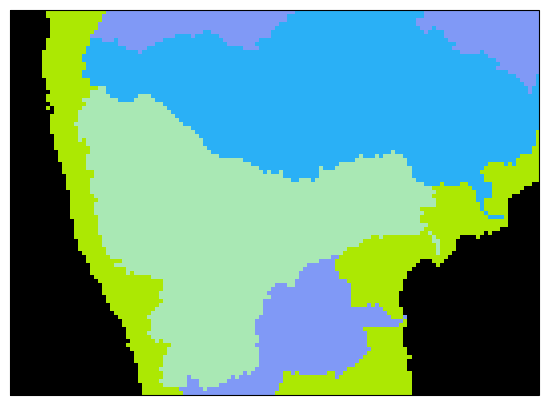

In [53]:
from matplotlib.colors import ListedColormap

def plot_basin(rivnum, unique_integers):
    num_labels = len(unique_integers)  # ラベル数
    print(num_labels)
    cmap = rand_cmap(1000, type='bright', first_color_black=True, verbose=False, seed=42)
    
    # 整数と色を対応付ける辞書を作成
    colors = cmap(np.linspace(0, 1, num_labels))
    integer_color_map = ListedColormap(colors)
    extent = (-180, 180, -90, 90)
    
    # extent
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(projection=projection)
    ax.set_extent(extent, projection)
    #ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    #ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=0)
    img = ax.imshow(rivnum,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=integer_color_map,
                   )
    
    west, east, south, north = 72, 83, 13, 21
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    
plot_basin(data, rivnum_unq_vld)

In [54]:
#pfaf4 ( x > 150,000 km2)
#glb_basin ( x > 20,000 km2, x <= 150,000 km2)
#data_from_ct ( x <= 20,000 km2 ) # 20,000 より大きい流域は分割している

# pfafArr: xxx xxxxx
# glb    :     xxxxx (max=675)
# data_ct:     xxxxx (max=10099)

# mergeするときにglbとdata_ctのidを振り変える
# pfafArr:   xxx xxxxx
# glb    : 1 xxx xxxxx  (org + 1e+8)
# data_ct: 2 xxx xxxxx  (org + 1e+8)

#9300092 100001
#675 94 
#50099 1
#outArr[maskArr_div3.data==1]=glb_basin[maskArr_div3.data==1]+1e+8
#outArr[maskArr_div3.data==0]=data_ct[maskArr_div3.data==0]+2e+8

#つまり6または7桁の数値の流域だけを対象にすれば150,000である．
#7桁の数値の最初の2桁はmain basin number
#7桁の数値の末尾の5桁はsub basin number

In [57]:
from collections import defaultdict

# 150,000 km2以上の流域
numbers = [i for i in rivnum_unq_vld if i < 1e8]

# グルーピング用の辞書
groups = defaultdict(list)

# 末尾5桁を除いた部分でグルーピング
for number in numbers:
    group_key = number // 100000  # 末尾5桁を除く
    groups[group_key].append(number)

# 150,000 未満の流域
numbers = [i for i in rivnum_unq_vld if i >= 1e8]

# 頭文字が 1 または 2 の値をそれぞれ別グループに分類して登録
for number in numbers:
    first_digit = int(str(number)[0])  # 数値の頭文字を取得
    if first_digit == 1:
        groups['group_1_head'].append(number)  # 頭文字が 1 の値を登録
    elif first_digit == 2:
        groups['group_2_head'].append(number)  # 頭文字が 2 の値を登録

# グループ数の確認
print(f"Total groups: {len(groups)}")

# グループ内容の確認（必要に応じて）
for key, group in groups.items():
    print(f"Group {key}: {group}")


Total groups: 95
Group 1: [100001, 100007, 100012, 100013, 100014, 100015, 100016, 100018, 100019, 100022, 100023, 100024, 100026, 100028, 100032, 100033, 100034, 100035, 100038, 100039, 100042, 100043, 100044, 100045, 100052, 100053, 100054, 100055, 100056, 100058, 100059, 100062, 100063, 100064, 100065, 100068, 100072, 100073, 100074, 100075, 100076, 100078, 100082, 100083, 100084, 100085, 100086, 100088, 100092, 100093, 100094, 100095, 100098, 100125, 100129, 100136, 100146, 100148, 100149, 100166, 100169, 100179, 100189, 100196, 100199, 100225, 100229, 100236, 100246, 100248, 100249, 100266, 100269, 100279, 100289, 100296, 100299, 100325, 100329, 100336, 100346, 100348, 100349, 100366, 100369, 100379, 100389, 100396, 100399, 100425, 100429, 100436, 100446, 100448, 100449, 100466, 100469, 100479, 100489, 100496, 100499, 100525, 100529, 100536, 100546, 100548, 100549, 100566, 100569, 100579, 100589, 100596, 100599, 100625, 100629, 100636, 100646, 100648, 100649, 100666, 100669, 10067

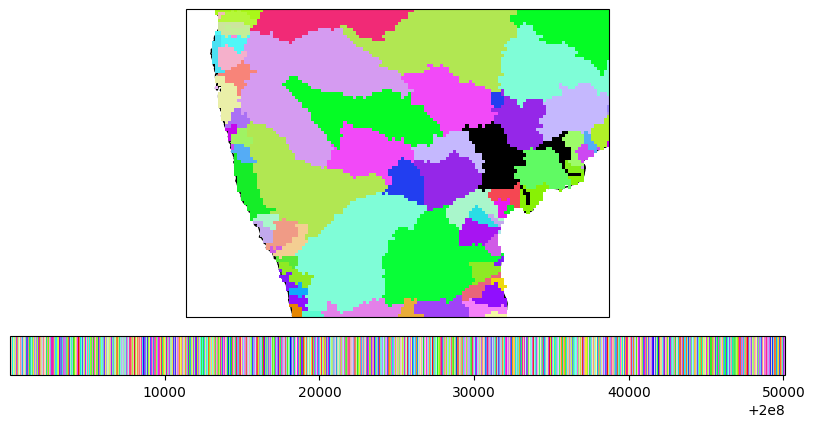

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
from random import randint

# グループごとのカラーマップを作成する関数
def create_group_cmaps(group_keys, group_values):
    group_cmaps = {}
    for group, values in zip(group_keys, group_values):
        cmap = rand_cmap(len(values), type='bright', first_color_black=True, verbose=False, seed=42)
        colors = cmap(np.linspace(0, 1, len(values)))
        group_cmaps[group] = (values, ListedColormap(colors))
    return group_cmaps

# プロット関数
def plot_basin(rivnum, group_cmaps):
    # extentの設定
    extent = (-180, 180, -90, 90)

    # 地図のプロジェクションを設定
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(projection=projection)

    # 地図の範囲を設定
    ax.set_extent(extent, projection)
    ax.coastlines(zorder=0)

    # 各グループごとに描画
    for group, (values, cmap) in group_cmaps.items():
        # マスクを作成
        masked_data = np.ma.masked_where(~np.isin(rivnum, values), rivnum)
        img = ax.imshow(masked_data, origin='upper', extent=extent, transform=projection, cmap=cmap)

    # ズーム範囲を設定
    west, east, south, north = 72, 83, 13, 21
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)

    plt.show()

# グループ定義と対応する値のリスト
group_keys = list(groups.keys())
group_values = list(groups.values())
group_cmaps = create_group_cmaps(group_keys, group_values)

# プロットを実行
plot_basin(data, group_cmaps)

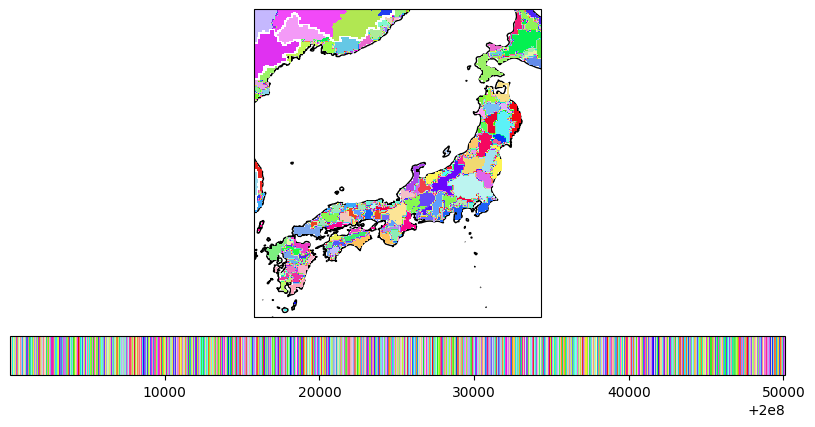

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
from random import randint

# グループごとのカラーマップを作成する関数
def create_group_cmaps(group_keys, group_values):
    group_cmaps = {}
    for group, values in zip(group_keys, group_values):
        cmap = rand_cmap(len(values), type='bright', first_color_black=True, verbose=False, seed=42)
        colors = cmap(np.linspace(0, 1, len(values)))
        group_cmaps[group] = (values, ListedColormap(colors))
    return group_cmaps

# プロット関数
def plot_basin(rivnum, group_cmaps):
    # extentの設定
    extent = (-180, 180, -90, 90)

    # 地図のプロジェクションを設定
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(projection=projection)

    # 地図の範囲を設定
    ax.set_extent(extent, projection)
    ax.coastlines(zorder=0)

    # 各グループごとに描画
    for group, (values, cmap) in group_cmaps.items():
        # マスクを作成
        masked_data = np.ma.masked_where(~np.isin(rivnum, values), rivnum)
        img = ax.imshow(masked_data, origin='upper', extent=extent, transform=projection, cmap=cmap)

    # ズーム範囲を設定
    west, east, south, north = 129, 143, 30, 45
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)

    plt.show()

# グループ定義と対応する値のリスト
group_keys = list(groups.keys())
group_values = list(groups.values())
group_cmaps = create_group_cmaps(group_keys, group_values)

# プロットを実行
plot_basin(data, group_cmaps)

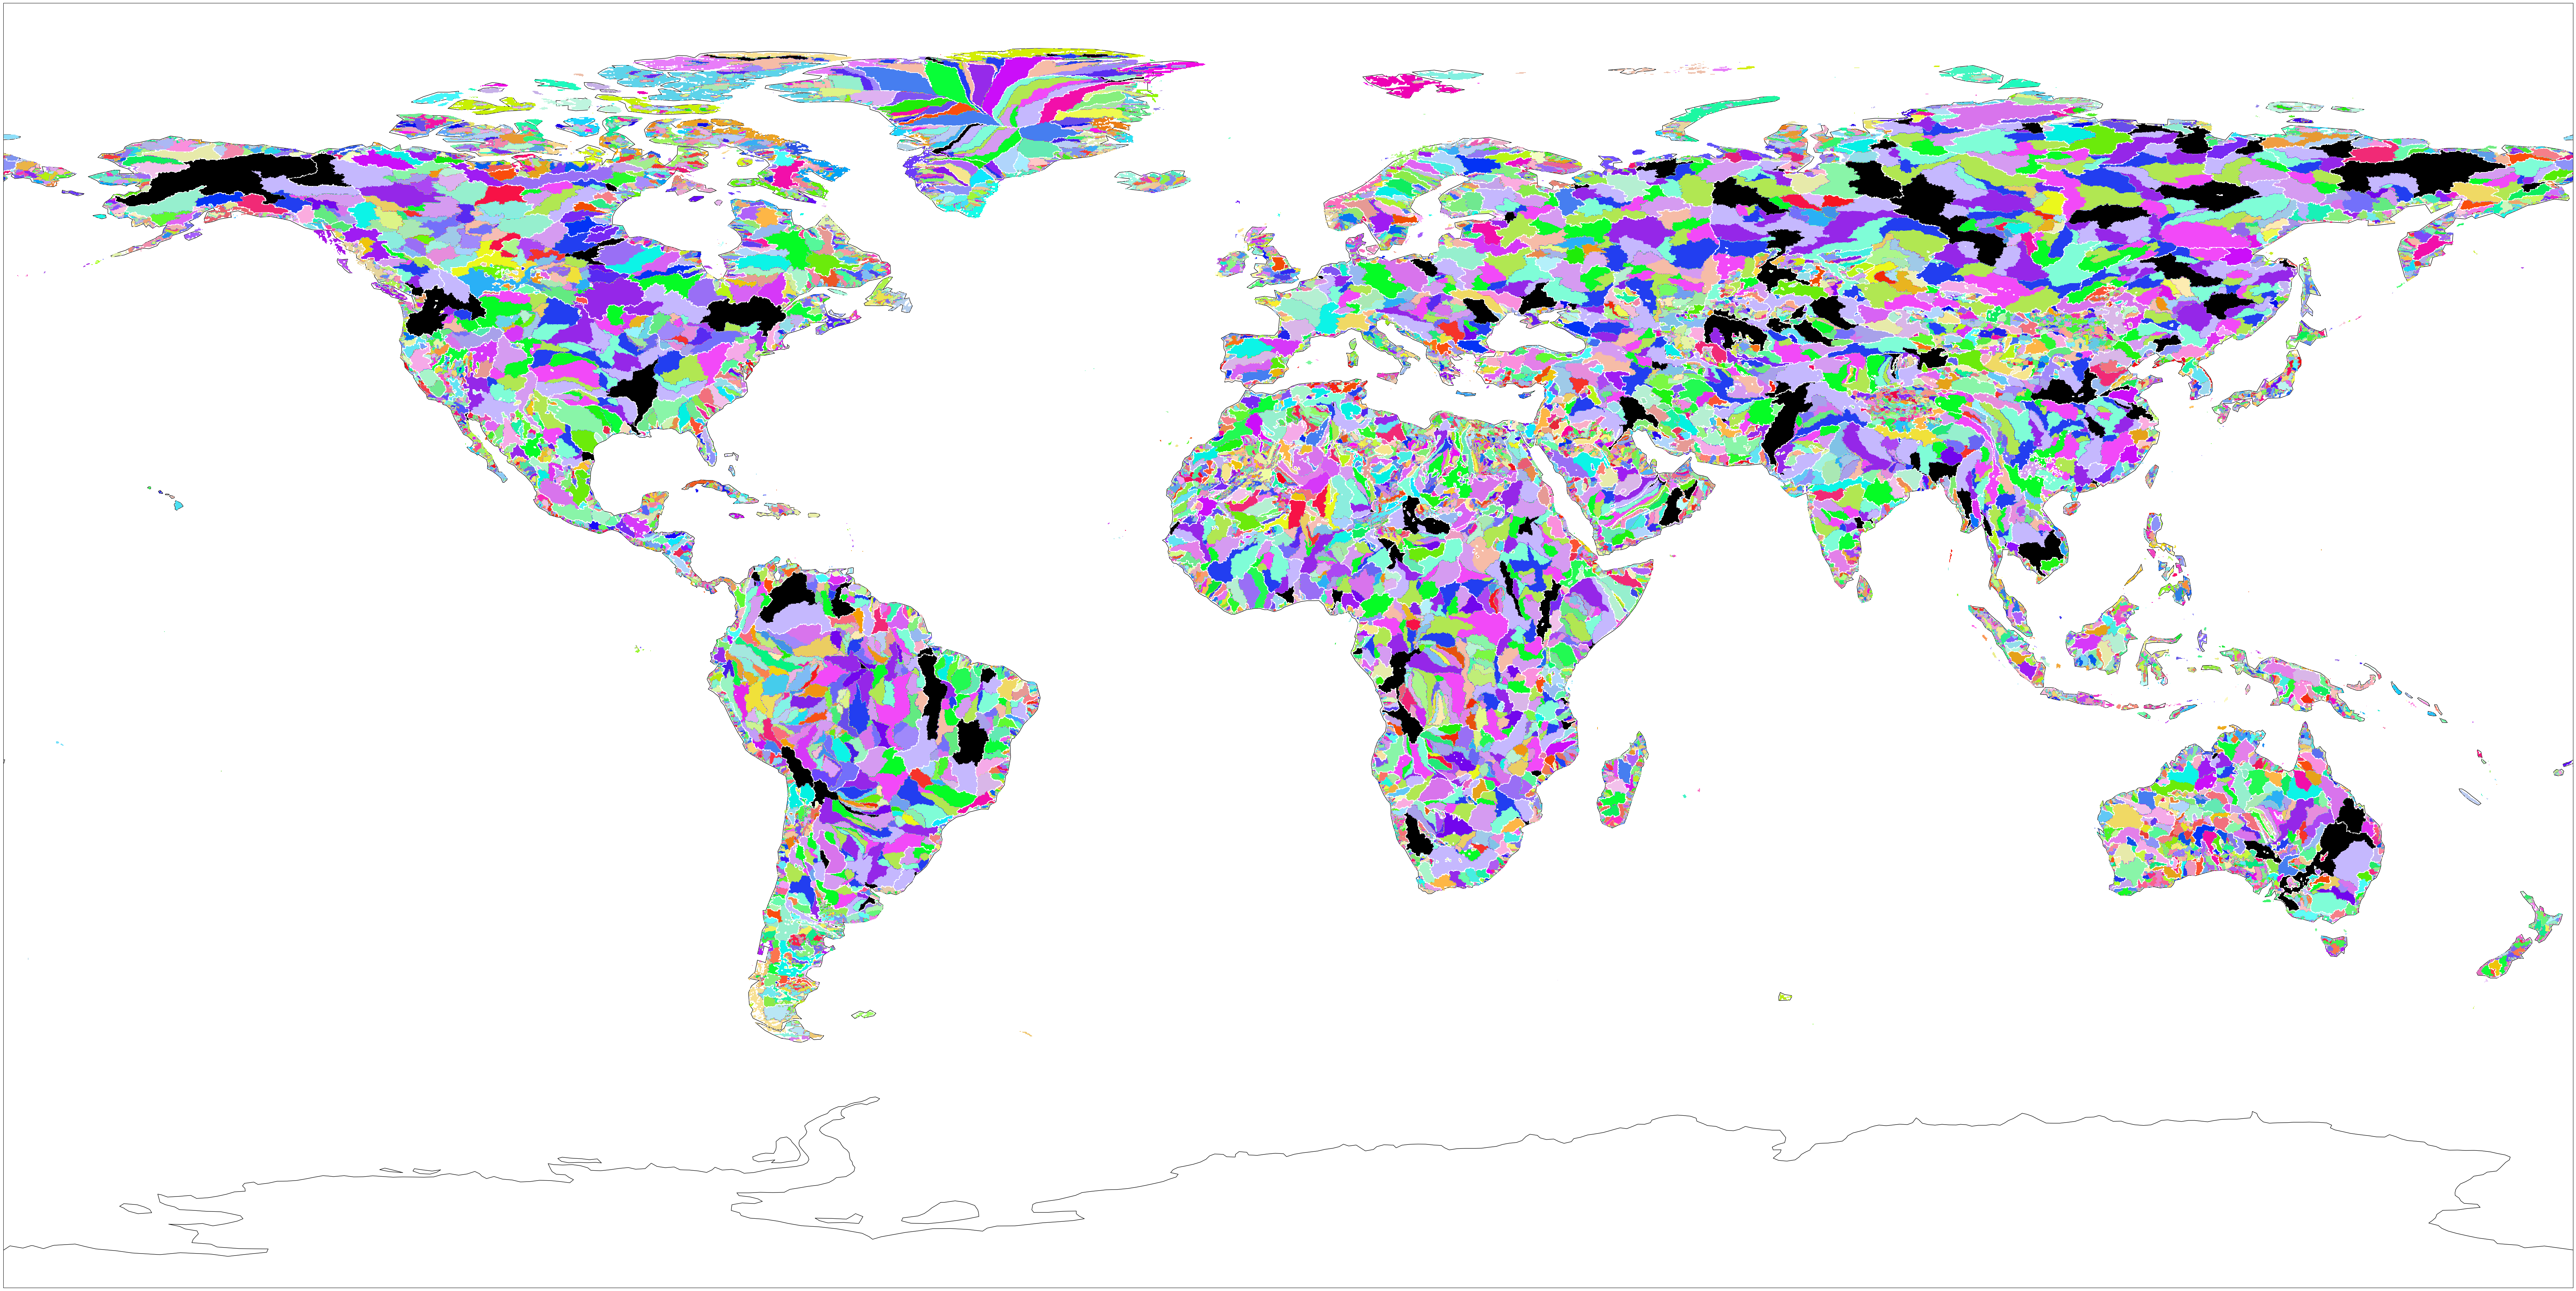

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
from random import randint

# グループごとのカラーマップを作成する関数
def create_group_cmaps(group_keys, group_values):
    group_cmaps = {}
    for group, values in zip(group_keys, group_values):
        cmap = rand_cmap(len(values), type='bright', first_color_black=True, verbose=False, seed=42)
        colors = cmap(np.linspace(0, 1, len(values)))
        group_cmaps[group] = (values, ListedColormap(colors))
    return group_cmaps

# プロット関数
def plot_basin(rivnum, group_cmaps):
    # extentの設定
    extent = (-180, 180, -90, 90)

    # 地図のプロジェクションを設定
    projection = ccrs.PlateCarree()
    fig = plt.figure(figsize=(100, 100))
    ax = plt.subplot(projection=projection)

    # 地図の範囲を設定
    ax.set_extent(extent, projection)
    ax.coastlines(zorder=0)

    # 各グループごとに描画
    for group, (values, cmap) in group_cmaps.items():
        # マスクを作成
        masked_data = np.ma.masked_where(~np.isin(rivnum, values), rivnum)
        img = ax.imshow(masked_data, origin='upper', extent=extent, transform=projection, cmap=cmap)

    plt.show()

# グループ定義と対応する値のリスト
group_keys = list(groups.keys())
group_values = list(groups.values())
group_cmaps = create_group_cmaps(group_keys, group_values)

# プロットを実行
plot_basin(data, group_cmaps)